Using Smopy means using OpenStreetMaps.  Per their usage rules: "Heavy use (e.g. distributing an app that uses tiles from openstreetmap.org) is forbidden without prior permission from the System Administrators. "

http://wiki.openstreetmap.org/wiki/Tile_usage_policy

In [107]:
import networkx as nx
import json
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = mpl.rcParams['savefig.dpi'] = 300

## Defining the functions

In [3]:
"""
    Each edge in the graph contains information about the road, including a list of points along this road. 
    We first create a function that returns this array of coordinates, for any edge in the graph.
"""

def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph, this function
    return an array of point coordinates along the road linking
    these two nodes."""
    return np.array(json.loads(gu[n0][n1]['Json'])['coordinates'])

In [2]:
"""
    Our path contains connected nodes in the graph. 
    Every edge between two nodes is characterized by a list of points (constituting a part of the road). 
    Therefore, we need to define a function that concatenates the positions along every edge in the path. 
    A difficulty is that we need to concatenate the positions in the right order along our path. 
    We choose the order based on the fact that the last point in an edge needs to be close to the first point in the next edge.
"""

def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path)-1):
        p = get_path(path[i], path[i+1])
        if curp is None:
            curp = p
        if np.sum((p[0]-curp)**2) > np.sum((p[-1]-curp)**2):
            p = p[::-1,:]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [4]:
#plot nodes, a function sometimes called in plt_edge
def plt_node(a,b, color='black', size=1):
    
    for x,y in zip(a,b):
        ax.plot(x,y, 'o', color=color, ms=size, markeredgewidth=0.0)

In [5]:
def plt_edge(mini_path, color, plot_nodes=False):
    mini_linepath = get_full_path(mini_path)
    mx, my = map.to_pixels(mini_linepath[:,1], mini_linepath[:,0])
    ax.plot(mx, my, '-k', lw=0.5, color=color)
    if plot_nodes:
        plt_node(mx, my)

## Work with data

Load the data (a Shapefile dataset) with NetworkX. 
This dataset contains detailed information about all roads in San Francisco County. 
NetworkX's read_shp function returns a graph, where each node is a geographical position, 
and each edge contains information about the road linking the two nodes.

Census maintains these files (http://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2016&layergroup=Roads)

In [6]:
g = nx.read_shp('Road files/data/tl_2016_06075_roads.shp')

#being directional means being unable to find edges unless in correct order
#so switch to unidirected
gu = g.to_undirected()

sg = list(nx.connected_component_subgraphs(g.to_undirected()))

### Visualize subgraphs

In [7]:
pos0 = (37.809776, -122.520686)
pos1 = (37.710163, -122.316753)
map = smopy.Map(pos0, pos1)

Lowered zoom level to keep map size reasonable. (z = 12)


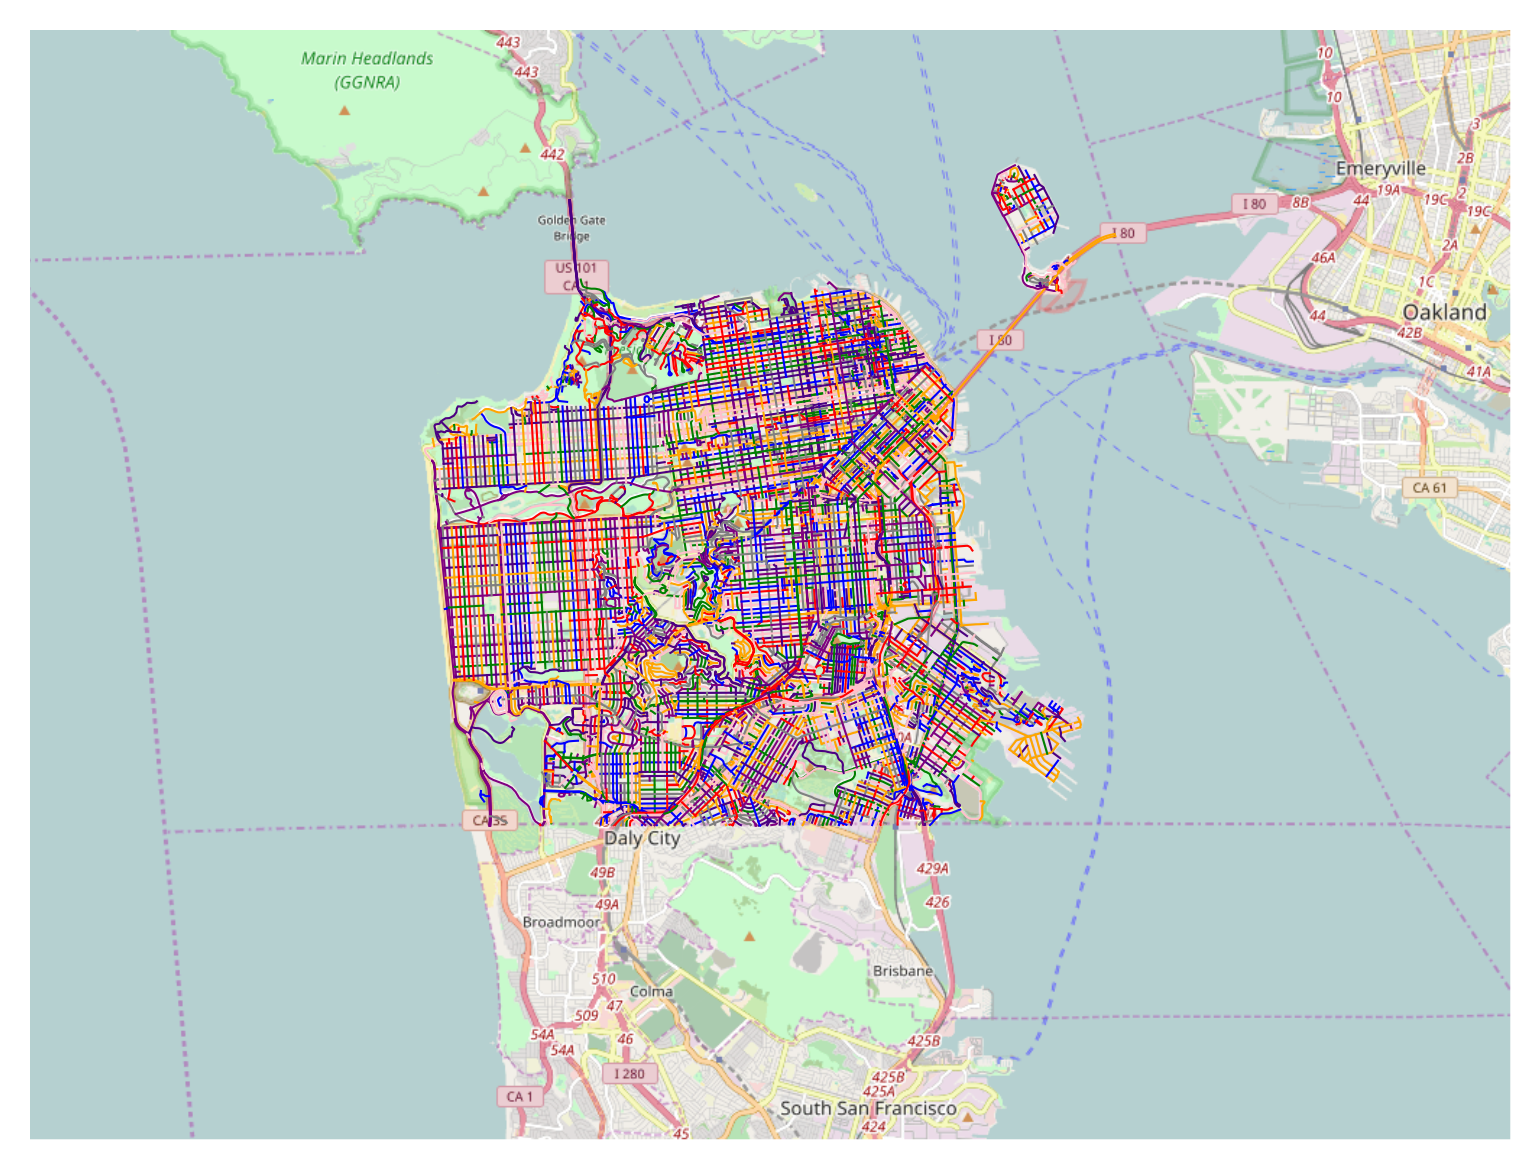

In [8]:
#pull subgraphs
sg_all = list(nx.connected_component_subgraphs(g.to_undirected()))

#get colors to rotate through
colors = ['red', 'blue', 'green', 'pink', 'grey', 'indigo', 'orange', 'purple']
l = len(colors)

ax = map.show_mpl()

for i in range(len(sg_all)):
    sg = sg_all[i]
    
    for e in sg.edges_iter():
        plt_edge(e, colors[i%l])

## Find closest 2 subgraphs

In [9]:
origin = (37.790509, -122.428106)

In [10]:
#pass in a spot and an edge, what's the closest it gets?
def get_edge_distance(my_spot, my_edge):
    my_points = get_full_path(my_edge)
    my_closest_distances = np.sum((my_points[:,::-1] - my_spot)**2, axis=1)
    my_closest_distance = my_closest_distances.min()
    my_closest_coordinate = my_points[np.argmin(my_closest_distances)]
    return my_closest_distance, my_closest_coordinate

In [11]:
#pass in a spot and a subgraph, what's the closest it gets?
def get_sg_distance(spot, my_sg):
    sg_distance = 100
    sg_coordinate = []
    for e in my_sg.edges_iter():
        edge_distance, edge_coordinate = get_edge_distance(spot, e)

        #if it's closest than any other edge, save it
        if edge_distance < sg_distance:
            sg_distance = edge_distance
            sg_coordinate = edge_coordinate
            my_edge = e

    return sg_distance, sg_coordinate, my_edge

In [12]:
#loop through subgraphs and find the closest two
#for some reason this won't work as a function
spot = origin
distances = []
coords = []
closest_edges = []

for sg in sg_all:
    distance, coord, closest_edge = get_sg_distance(spot, sg)
    distances.append(distance)
    coords.append(coord)
    closest_edges.append(closest_edge)

df = pd.DataFrame(data={'distance': distances
                        ,'coord': coords
                       ,'edge': closest_edges})
df.sort_values(by='distance', inplace=True)
df = df[0:2]

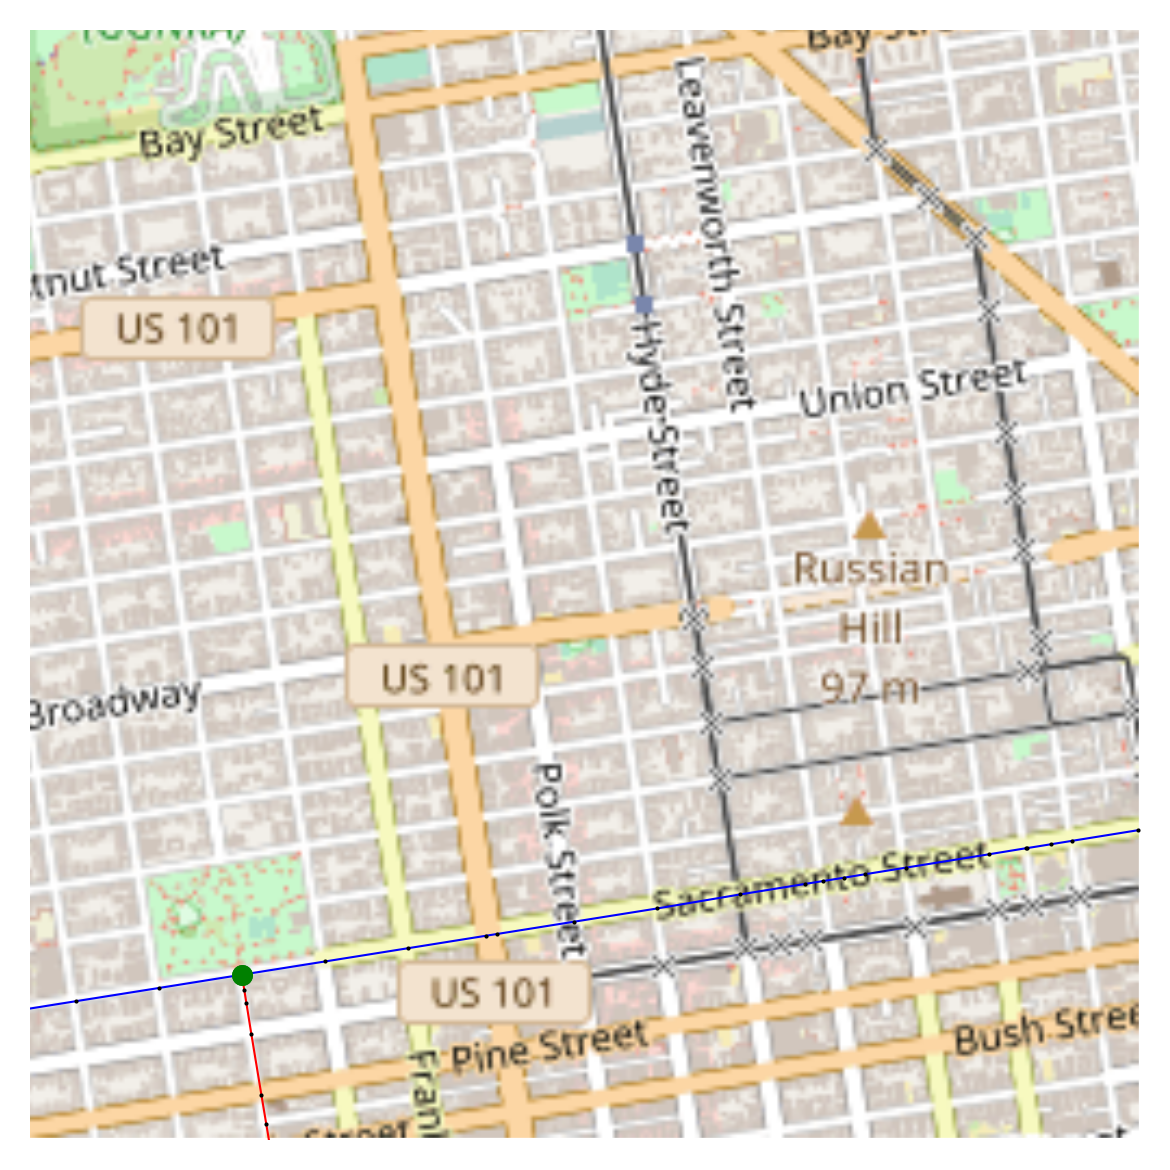

In [13]:
#plot

map = smopy.Map(origin, z=14)

#take the distances, sort, pop top two and use those indices to plot
closest_sg_i = df.index.tolist()

#get colors to rotate through
colors = ['red', 'blue']

ax = map.show_mpl()

for i in range(2):
    sg = sg_all[closest_sg_i[i]]
    
    for e in sg.edges_iter():
        plt_edge(e, colors[i%l], True)
#        test_b = e
        
#take two closest points and map them
nx, ny = map.to_pixels(np.array([z[1] for z in df.coord]), np.array([z[0] for z in df.coord]))
plt_node(nx, ny, color='green', size=5)

## Connect closest subgraphs, and find next closest for inspection

In [103]:
# combine subgraphs with a shared coordinate

if tuple(df.coord.iloc[0])==tuple(df.coord.iloc[1]):
    #pull the closest coordinate and get it prepped to be added (or called) as a node
    origin_coord = tuple(df.coord.iloc[0])

    #loop through nodes, creating an edge to each with the origin coordinate
    for listed_edge in df.edge:
        for node_coord in listed_edge:
            if gu.has_edge(origin_coord, node_coord) is False:
                #add the edge connecting existing node to origin
                gu.add_edge(node_coord, origin_coord)

                #store the two coordinates in the Json property
                my_dict = {'coordinates': [node_coord, origin_coord]}
                gu[node_coord][origin_coord]['Json'] = json.dumps(my_dict)

just a copy of above to loop through and find two closest subgraphs

In [113]:
#loop through subgraphs and find the closest two
#for some reason this won't work as a function
spot = origin
distances = []
coords = []
closest_edges = []

for sg in sg_all_2:
    distance, coord, closest_edge = get_sg_distance(spot, sg)
    distances.append(distance)
    coords.append(coord)
    closest_edges.append(closest_edge)

df = pd.DataFrame(data={'distance': distances
                        ,'coord': coords
                       ,'edge': closest_edges})
df.sort_values(by='distance', inplace=True)
df = df[0:2]

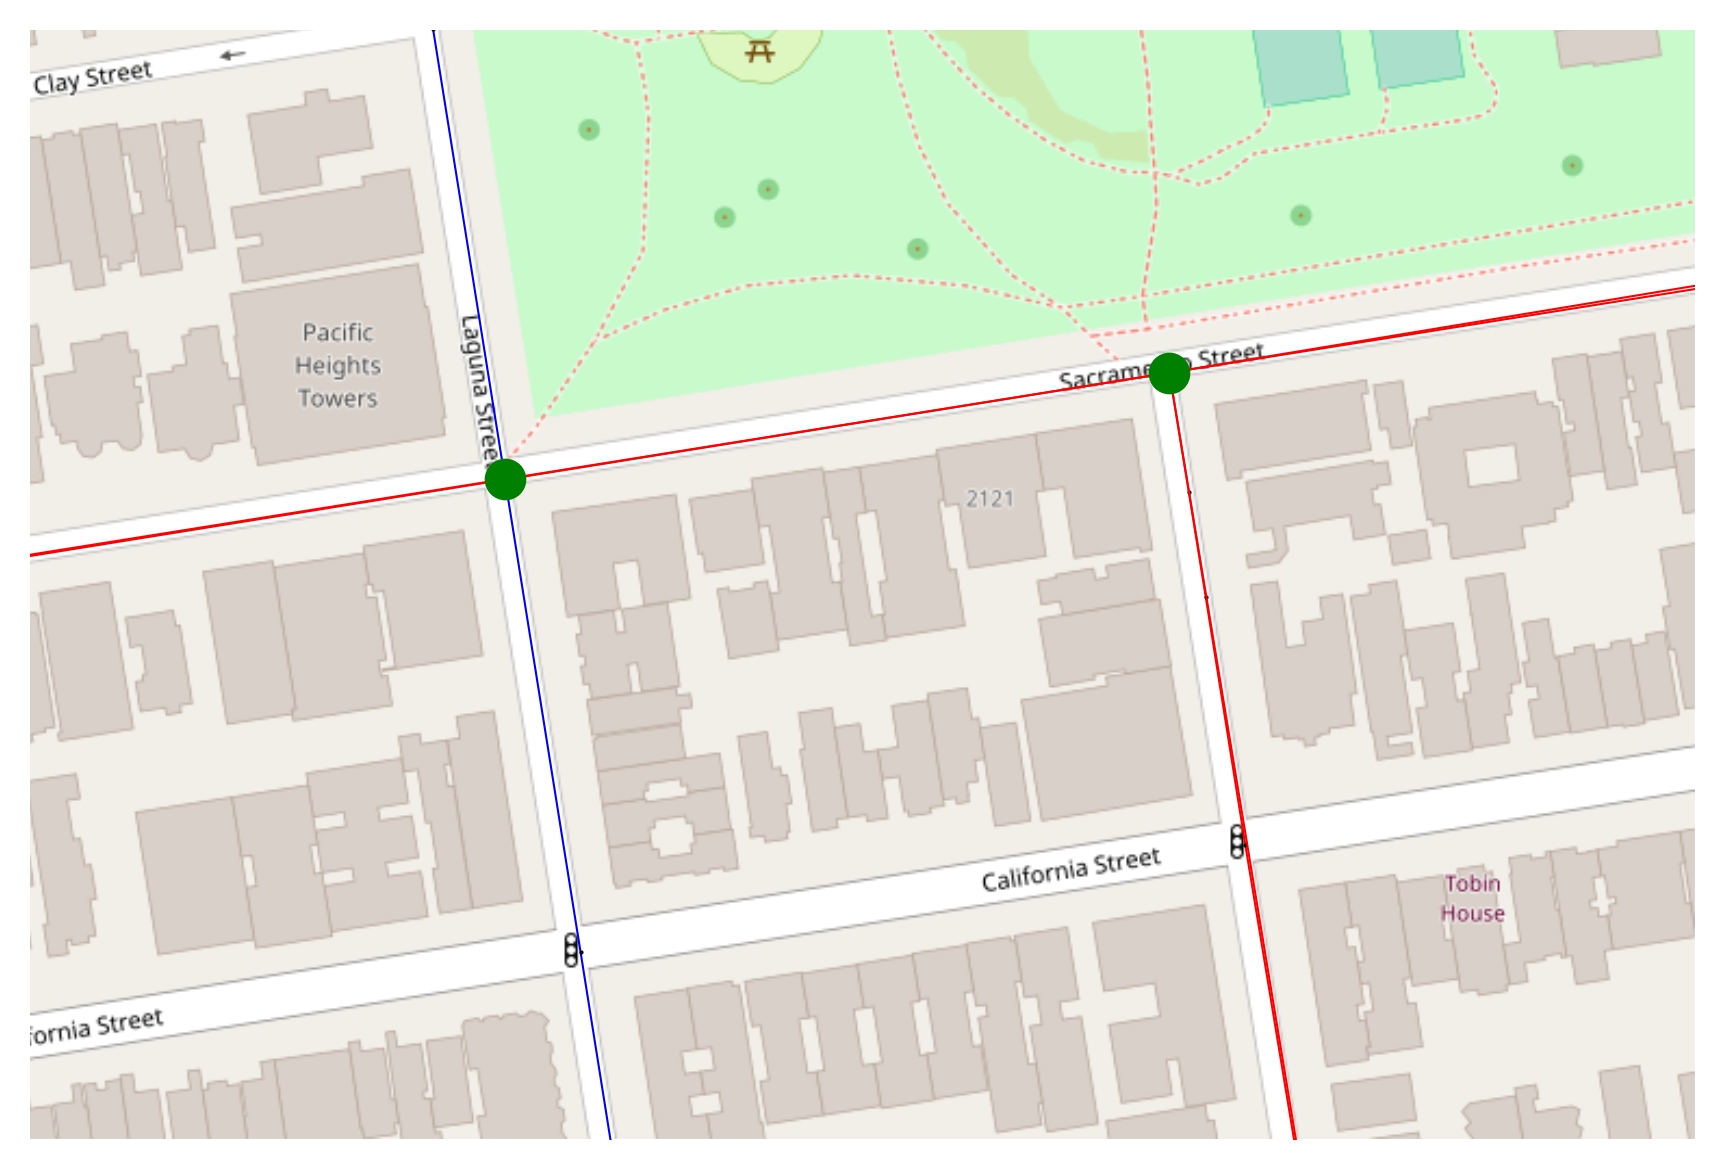

In [133]:
#plot

map = smopy.Map((37.790667,-122.427448), (37.790459, -122.429092))

#take the distances, sort, pop top two and use those indices to plot
closest_sg_i = df.index.tolist()

#get colors to rotate through
colors = ['red', 'blue']

ax = map.show_mpl()

for i in range(2):
    sg = sg_all_2[closest_sg_i[i]]
    
    for e in sg.edges_iter():
        plt_edge(e, colors[i%l], True)
#        test_b = e
        
#take two closest points and map them
nx, ny = map.to_pixels(np.array([z[1] for z in df.coord]), np.array([z[0] for z in df.coord]))
plt_node(nx, ny, color='green', size=10)

## scratch

In [112]:
len(sg_all_2)

2633

In [128]:
connector

(-122.427448, 37.790666999999999)

In [130]:
df.edge.iloc[1]

((-122.459256, 37.786623), (-122.394324, 37.79499599999999))